# Proyecto de Simulación

## David Sánchez Iglesias

### Librerías:

In [1199]:
import numpy as np
from scipy import stats
from scipy.special import erfcinv
import matplotlib.pyplot as plt
import heapq
from numpy.random import default_rng

### Modelo de Seguros de Riesgo:

In [1200]:
class InsuranceRiskModel:
                                                                                            #new_pol_fun,
    def __init__(self, new_pol_rate, lost_pol_rate, starting_capital, starting_policy_holders,        pol_time_fun, next_claim, claim_rate, limit_time, pol_pay):
        self.new_pol_rate = new_pol_rate
        self.lost_pol_rate = lost_pol_rate
        self.claim_rate = claim_rate
        
        self.time_pol_in_firm_func = pol_time_fun
        self.claim_fun = next_claim
        
        #vars de referencia
        self.limit_time = limit_time
        self.pol_pay = pol_pay
        self.starting_capital = starting_capital
        self.initial_n_pols = starting_policy_holders
        self.current_pol_id = 1
        
        #estadisticas de varias simulaciones
        self.S_new_pols = []
        self.S_lost_pols = []
        self.S_claims = []
        self.S_capital = []
        self.S_capital_history = []
        self.S_time_steps = []
        
        self.rng = default_rng()
        
        self.initialize()
        
    def initialize(self):
        self.time = 0
        self.capital = self.starting_capital
        self.n_pols = self.initial_n_pols
        self.lost_pols = 0
        self.events_queue = []
        self.events = {'new_policyholder': self.new_policyholder,
                       'lost_policyholder': self.lose_policyholder,
                       'claim': self.next_claim}
        self.pol_list = []
        
        #Meter en la firma n_pols policyholders
        for i in range(self.n_pols):
            # Determino cuando dejaran de ser policyholders.
            t_e = self.time_pol_in_firm_func(self.lost_pol_rate)
            t_e = self.time + t_e
            # Y agrego los eventos para simularlos.
            if t_e < self.limit_time:
                heapq.heappush(self.events_queue, (t_e, 'lost_policyholder', i))
                self.pol_list.append(i)
                
        #Estadisticas
        self.new_pols = {} #{pol_id: time}
        self.pols_lost = {} #{pol_id: time}
        self.claims = {} #{time: amount}
        # self.capital_history = {self.time: self.capital}
        
        self.time_steps = [0]
        self.capital_history = [self.starting_capital]
        self.policyholder_count = [self.initial_n_pols]
        self.earnings = {}
        # self.claims_time = []
        # self.claims_amount = []
        # self.policy_lifecycles = [] 
        
    
    def next_new_policyholder(self):
        if self.time >= self.limit_time:
            return None
        t_e = self.rng.poisson(self.new_pol_rate)
        t_e = self.time + t_e
        if t_e < self.limit_time:
            heapq.heappush(self.events_queue, (t_e, 'new_policyholder'))
    
    def new_policyholder(self):
        pol_id = self.current_pol_id#para q no se repitan los ids, n_pols + lost_pols son la totalidad de pols q pasaron por la empresa hasta ahora.
        self.current_pol_id += 1
        self.n_pols += 1
        # Genero el tiempo de permanencia
        t_e = self.time_pol_in_firm_func(self.lost_pol_rate)
        t_e = self.time + t_e
        if t_e < self.limit_time:
            heapq.heappush(self.events_queue, (t_e, 'lost_policyholder', pol_id))
            self.pol_list.append(pol_id)
            self.new_pols[pol_id] = self.time
            self.next_new_policyholder()
    
    def lose_policyholder(self, pol_id):
        self.n_pols -= 1
        self.pol_list.remove(pol_id)
        self.lost_pols += 1
        self.pols_lost[pol_id] = self.time
        
    #Una reclamacion viene con una cantidad de dinero que distribuye F (asumo F por defecto como exponencial)
    def next_claim(self):
        t_e, money = self.claim_fun(self.claim_rate)
        t_e = self.time + t_e
        if t_e < self.limit_time:
            heapq.heappush(self.events_queue, (t_e, 'claim', money))
        
    def run(self):
        self.next_new_policyholder()
        self.next_claim()
        while self.time <= self.limit_time:
            if not self.events_queue:
                #Si la cola esta vacia es porq no ocurre ningun otro evento antes del tiempo limite.
                break
            event_tuple = heapq.heappop(self.events_queue)
            event_time = event_tuple[0]
            self.capital = self.capital + self.n_pols * self.pol_pay * (event_time - self.time)
            self.earnings[(self.time, event_time)] = self.n_pols * self.pol_pay
            self.time = event_time
            event_type = event_tuple[1]
            
            if event_type == 'new_policyholder':
                self.events[event_type]()
            elif event_type == 'lost_policyholder':
                self.events[event_type](event_tuple[2])
            elif event_type == 'claim':
                self.capital -= event_tuple[2]
                self.events[event_type]()
                self.claims[self.time] = event_tuple[2]
                # self.claims_time.append(self.time)
                # self.claims_amount.append(event_tuple[2])
                
            self.capital_history.append(self.capital)
            self.time_steps.append(self.time)
            self.policyholder_count.append(self.n_pols)
            
        
    def simulate(self, times):
        for _ in range(times):
            self.initialize()
            self.run()
            self.S_new_pols.append(self.new_pols)
            self.S_lost_pols.append(self.pols_lost)
            self.S_claims.append(self.claims)
            self.S_capital.append(self.capital)
            self.S_capital_history.append(self.capital_history)
            self.S_time_steps.append(self.time_steps)
            
    


In [1201]:
# def new_client(rate):
#     return np.random.poisson(rate)

def policyholder_time_in_the_firm(rate):
    return np.random.exponential(1/rate)

def new_claim(rate, money_fun=None):
    """Devuelve el tiempo en el que se producira una reclamacion junto con el dinero que se reclamara."""
    if money_fun is None:
        return (np.random.poisson(rate), np.random.exponential(1))
    return (np.random.poisson(rate), money_fun())

## Iniciando el modelo:

In [1202]:
model = InsuranceRiskModel(
    new_pol_rate=20,           # 15 nuevos clientes/mes
    lost_pol_rate=0.05,        # 5% de clientes se pierden
    starting_capital=1_00,
    starting_policy_holders=500,
    pol_time_fun= policyholder_time_in_the_firm, 
    next_claim= new_claim, 
    claim_rate= 5,
    limit_time=120,             # 120 meses (10 años)
    pol_pay=150                 # $150 por póliza/mes
)

## Ejecutando el modelo

In [1203]:
model.run()

## Experimentos

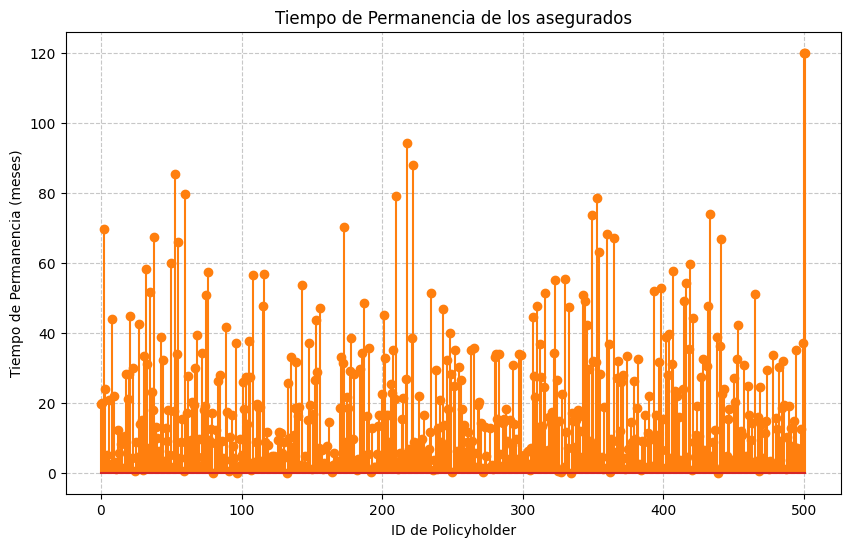

Tiempo maximo de permanencia de un policyholder:  120
Tiempo minimo de permanencia de un policyholder:  0.0006715995868982385


In [1204]:
# Tiempo que ha permanecido cada asegurado con la firma
total_times = {}
for pol_id in range(model.n_pols + model.lost_pols):
    if pol_id in model.new_pols.keys():
        start_time = model.new_pols[pol_id]
    else:
        start_time = 0
    if pol_id in model.pols_lost.keys():
        end_time = model.pols_lost[pol_id]
    else:
        end_time = model.limit_time
    total_times[pol_id] = end_time - start_time
    
plt.figure(figsize=(10, 6))
plt.stem(range(len(total_times.keys())), total_times.values(), 'C1-')
plt.xlabel('ID de Policyholder')
plt.ylabel('Tiempo de Permanencia (meses)')
plt.title('Tiempo de Permanencia de los asegurados')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print('Tiempo maximo de permanencia de un policyholder: ', max(total_times.values()))
print('Tiempo minimo de permanencia de un policyholder: ', min(total_times.values()))
    

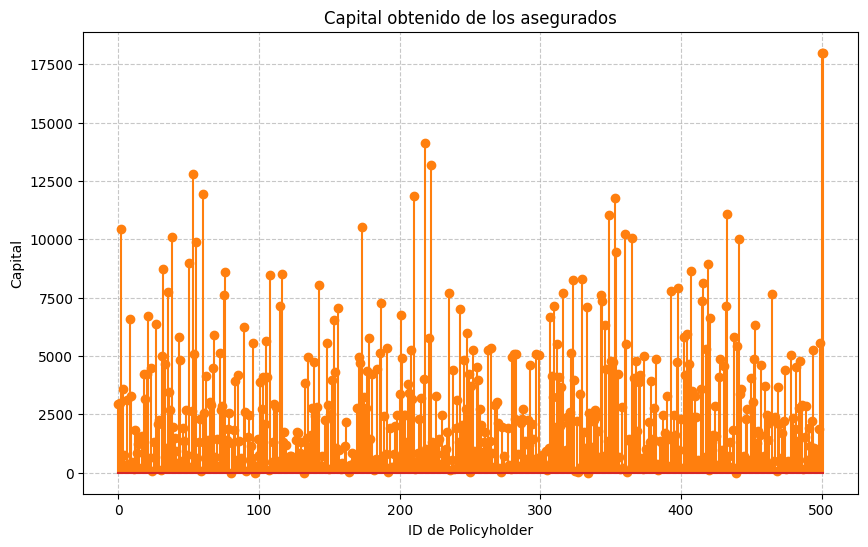

In [1205]:
#Capital obtenido de cada asegurado

capital_by_pol = {}
for pol_id, time in total_times.items():
    capital_by_pol[pol_id] = time * model.pol_pay

plt.figure(figsize=(10, 6))
plt.stem(range(len(capital_by_pol.keys())), capital_by_pol.values(), 'C1-')
plt.xlabel('ID de Policyholder')
plt.ylabel('Capital')
plt.title('Capital obtenido de los asegurados')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

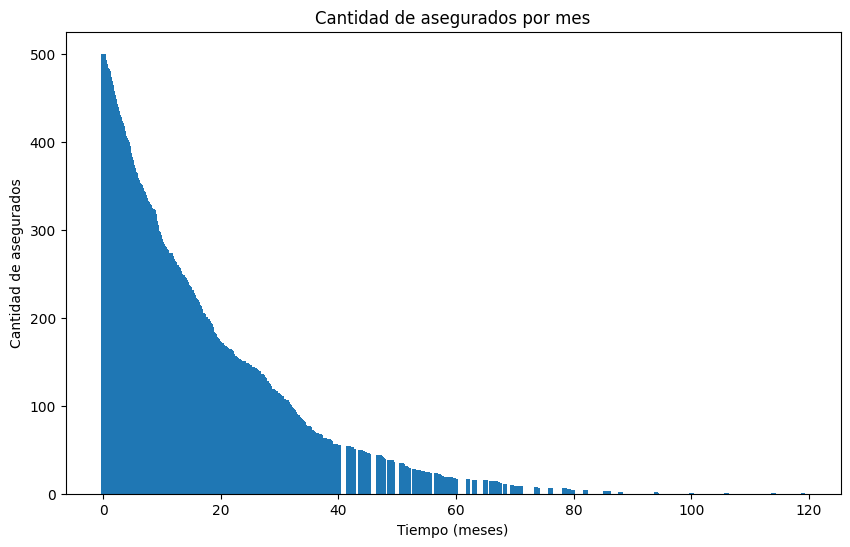

In [1206]:
#Cantidad de asegurados en cada unidad de tiempo

plt.figure(figsize=(10, 6))
plt.bar(model.time_steps, model.policyholder_count)
plt.xlabel('Tiempo (meses)')
plt.ylabel('Cantidad de asegurados')
plt.title('Cantidad de asegurados por mes')
plt.show()


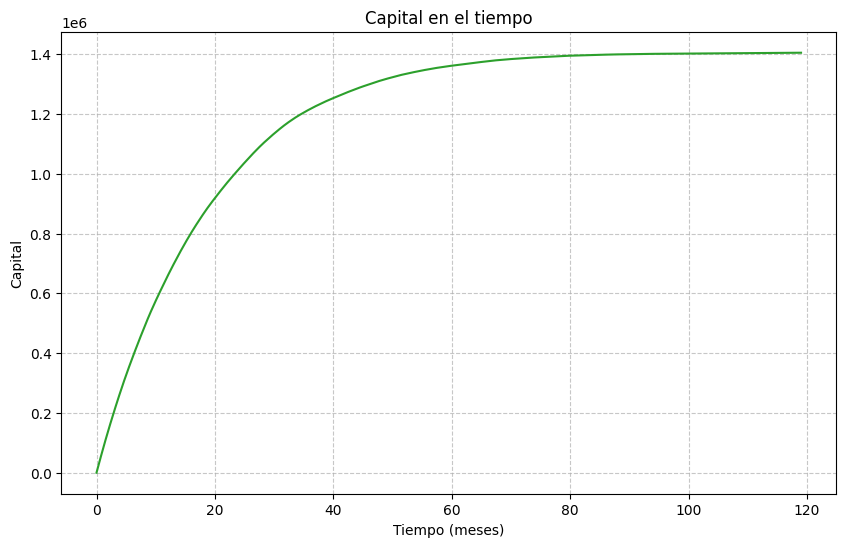

Capital total:  1404987.3192782088


In [1207]:
#Ganancias totales

plt.figure(figsize=(10, 6))
plt.plot(model.time_steps, model.capital_history, 'C2-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Capital')
plt.title('Capital en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print('Capital total: ', model.capital)

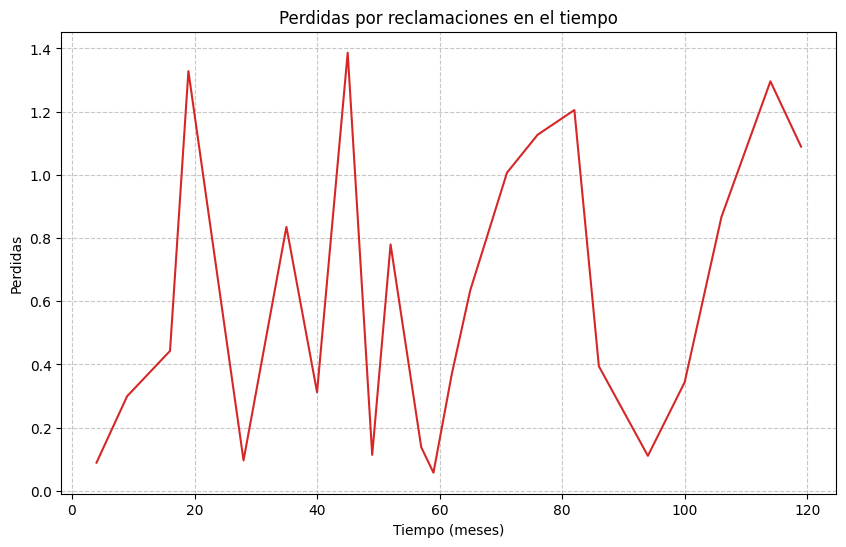

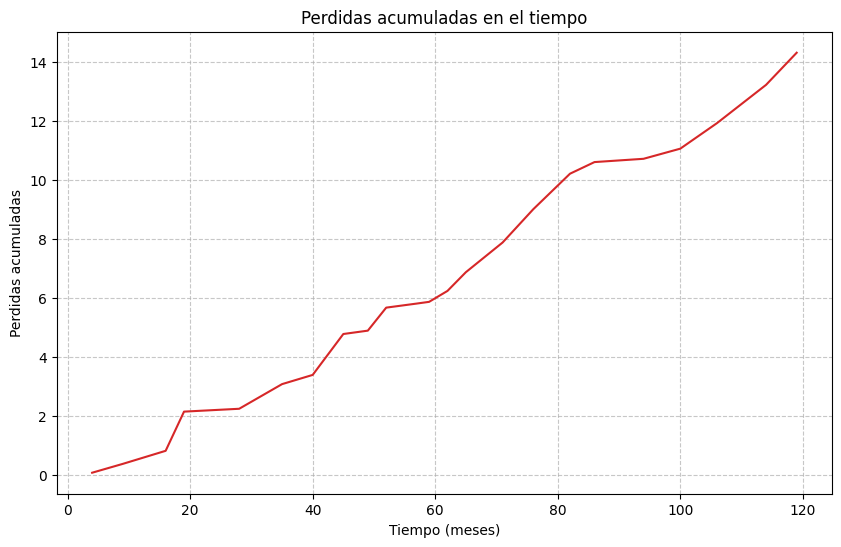

Perdidas totales:  14.323916027968183


In [1208]:
#Perdidas totales

plt.figure(figsize=(10, 6))
plt.plot(model.claims.keys(), model.claims.values(), 'C3-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Perdidas')
plt.title('Perdidas por reclamaciones en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#Perdida acumulada
acumulacion = []
for claim in model.claims.keys():
    if acumulacion == []:
        acumulacion.append(model.claims[claim])
    else:
        acumulacion.append(acumulacion[-1] + model.claims[claim])


plt.figure(figsize=(10, 6))
plt.plot(model.claims.keys(), acumulacion, 'C3-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Perdidas acumuladas')
plt.title('Perdidas acumuladas en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print('Perdidas totales: ', sum(model.claims.values()))

In [1209]:
# #Media de asegurados
# plt.figure(figsize=(10, 6))
# plt.plot(model.time_steps, model.policyholder_count, 'C4-')
# plt.xlabel('Tiempo (meses)')
# plt.ylabel('Cantidad de Policyholders')
# plt.title('Cantidad de Policyholders en el tiempo')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

# print('Media de asegurados: ', np.mean(model.policyholder_count))

## Simulemos mas veces

In [1210]:
model.simulate(1000)

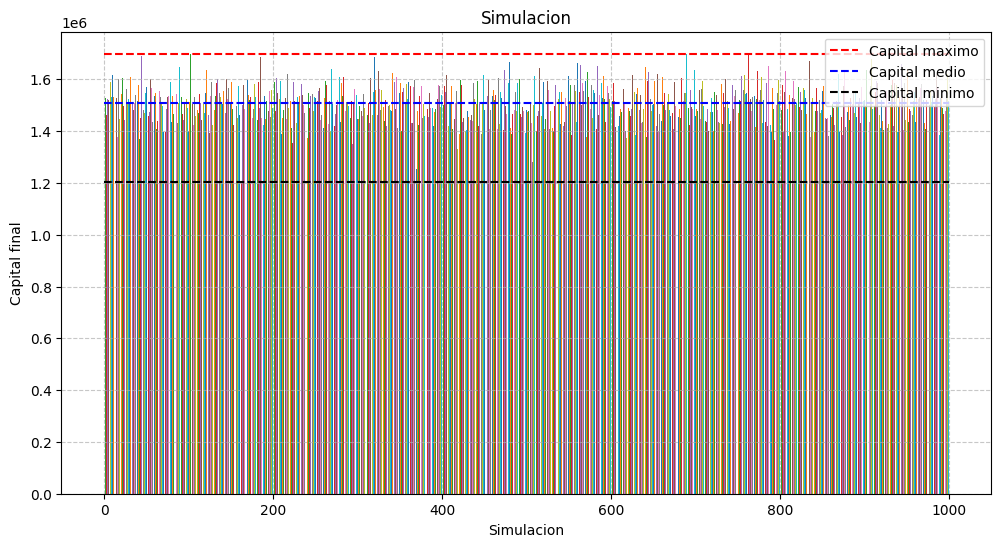

Capital medio:  1507926.1929569421


In [1222]:
#Comparacion entre los capitales totales
plt.figure(figsize=(12, 6))
for i in range(1000):
    plt.bar(i, model.S_capital[i])
#Poner linea horizontal discontinua que llegue al eje y y se marque en la grafica para marcar el mayor valor
plt.hlines(max(model.S_capital), 0, 1000, colors='red', linestyles='dashed', label='Capital maximo')
plt.hlines(np.mean(model.S_capital), 0, 1000, colors='blue', linestyles='dashed', label='Capital medio')
plt.hlines(min(model.S_capital), 0, 1000, colors='black', linestyles='dashed', label='Capital minimo')
plt.legend()
plt.xlabel('Simulacion')
plt.ylabel('Capital final')
plt.title('Simulacion')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print('Capital medio: ', np.mean(model.S_capital))

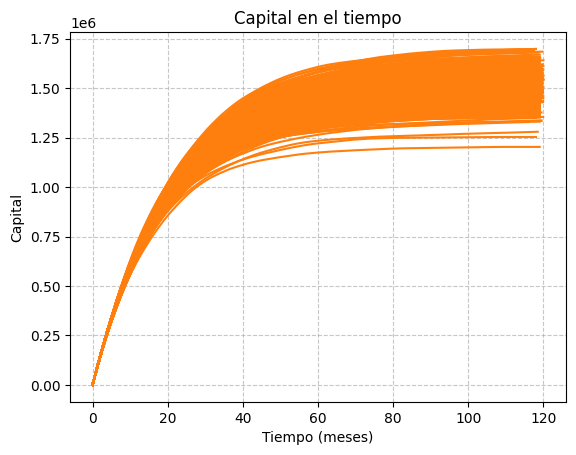

In [1212]:

#Compara las capital_history de los 1000 simulaciones

for i in range(1000):
    plt.plot(model.S_time_steps[i], model.S_capital_history[i], 'C1-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Capital')
plt.title('Capital en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Method for Determining When to Stop Generating New Data
# acceptable_d = 5
# n_sim = 100
# data_values = []
# c=erfcinv(0.005)

# while True:
#     model.simulate(n_sim)
#     for i in range(n_sim):
#         capital = model.S_capital[i]
#         data_values.append(capital)
#     sample_std_dev = np.std(data_values)
    
#     if c * (sample_std_dev/np.sqrt(len(data_values))) < acceptable_d:
#         print(f'Media estimada: {np.mean(data_values)}')
#         break
#     n_sim = 100

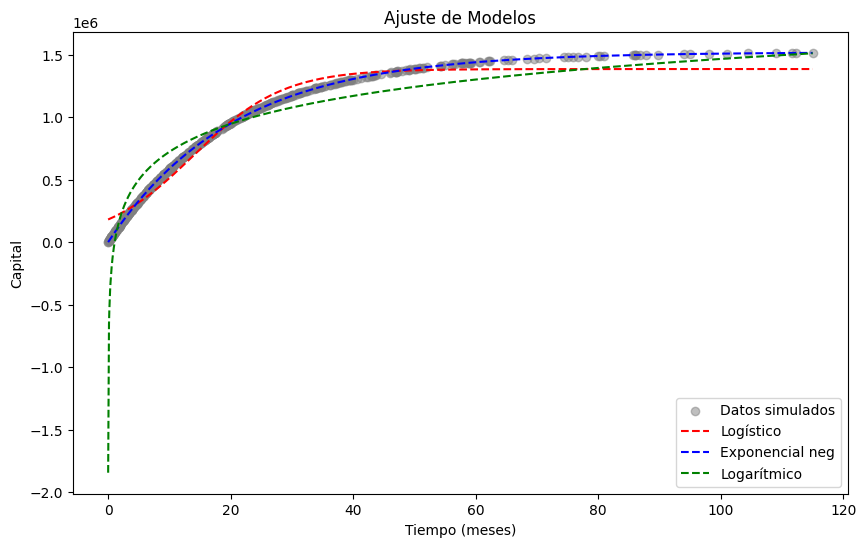

In [1229]:
from scipy.optimize import curve_fit

# Ejemplo: Datos de tiempo (t) y capital (C) de una simulación
t = np.array(model.time_steps)  # Convertir a numpy array
C = np.array(model.capital_history)  # Convertir a numpy array

# Definir modelos candidatos
def modelo_logistico(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

def modelo_exponencial_neg(t, L, k):
    return L * (1 - np.exp(-k * t))

def modelo_logaritmico(t, a, b):
    return a + b * np.log(t)

def modelo_inverso(t, a, b):
    return a - b / t

# Ajustar parámetros
params_logistic, _ = curve_fit(modelo_logistico, t, C, p0=[1e6, 0.1, 60])
params_exp_neg, _ = curve_fit(modelo_exponencial_neg, t, C, p0=[1e6, 0.1])
params_log, _ = curve_fit(modelo_logaritmico, t[1:], C[1:], p0=[1e6, 1e5])  # log(0) no existe
params_inv, _ = curve_fit(modelo_inverso, t[1:], C[1:], p0=[3e6, 1e6])

# Graficar ajustes
plt.figure(figsize=(10, 6))
plt.scatter(t, C, label='Datos simulados', color='gray', alpha=0.5)
plt.plot(t, modelo_logistico(t, *params_logistic), 'r--', label='Logístico')
plt.plot(t, modelo_exponencial_neg(t, *params_exp_neg), 'b--', label='Exponencial neg')
plt.plot(t[1:], modelo_logaritmico(t[1:], *params_log), 'g--', label='Logarítmico')
# plt.plot(t[1:], modelo_inverso(t[1:], *params_inv), 'm--', label='Inverso')
plt.legend()
plt.xlabel('Tiempo (meses)')
plt.ylabel('Capital')
plt.title('Ajuste de Modelos')
plt.show()

Text(0, 0.5, 'Residuales')

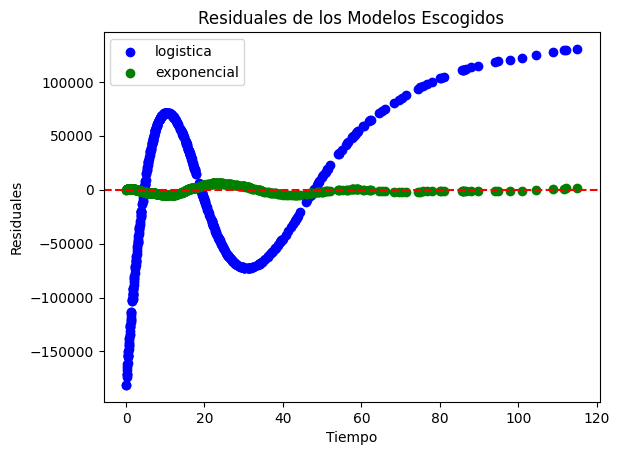

In [1232]:
residuales1 = C - modelo_logistico(t, *params_logistic)
residuales2 = C - modelo_exponencial_neg(t, *params_exp_neg)
# residuales3 = C[1:] - modelo_logaritmico(t[1:], *params_log)
# residuales4 = C[1:] - modelo_inverso(t[1:], *params_inv)
plt.scatter(t, residuales1, color='blue', label='logistica')
plt.scatter(t, residuales2, color='green', label="exponencial")
# plt.scatter(t[1:], residuales3)
# plt.scatter(t[1:], residuales4)
plt.legend()
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuales de los Modelos Escogidos')
plt.xlabel('Tiempo')
plt.ylabel('Residuales')

Aqui vemos que el modelo exponencial es el que se ajusta más.

In [1216]:
# Error cuadratico medio normalizado
# Normalizado por la varianza (estimado de la varianza: la media de los valores)
# Estimador de la varianza (omega^2)
mean = np.mean(C)
var = 0
for i in range(len(C)):
    var += (C[i] - mean)**2
var = var/len(C) - 1

print('Error cuadratico medio del modelo exponencial negativo: ', np.mean(residuales1**2))
print('Normalizado: ', np.mean(residuales2**2)/var)
print('Varianza: ',var)

Error cuadratico medio del modelo exponencial negativo:  4624655988.021224
Normalizado:  5.0556551373477e-05
Varianza:  207166182935.46295


In [1217]:
# #Comparacion entre los pols perdidos
# sums = []
# for i in range(1000):
#     sums.append(sum(model.S_lost_pols[i]))
    
# plt.figure(figsize=(12, 6))
# for i in range(1000):
#     plt.bar(i, sums[i])
# #Poner linea horizontal discontinua que llegue al eje y y se marque en la grafica para marcar el mayor valor
# plt.hlines(max(sums), 0, 1000, colors='red', linestyles='dashed', label='Perdidas maximo')
# plt.hlines(np.mean(sums), 0, 1000, colors='blue', linestyles='dashed', label='Perdidas medio')
# plt.hlines(min(sums), 0, 1000, colors='black', linestyles='dashed', label='Perdidas minimo')
# plt.legend()

# plt.xlabel('Simulacion')
# plt.ylabel('Asegurados perdidos')
# plt.title('Simulacion')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

In [1218]:


# # Cuanto tiempo ha permanecido cada policy holder con la firma?(analizando una sola simulacion)
# total_times = {}
# for pol_id in range(model.n_pols + model.lost_pols):
#     if pol_id in model.new_pols.keys():
#         start_time = model.new_pols[pol_id]
#     else:
#         start_time = 0
#     if pol_id in model.pols_lost.keys():
#         end_time = model.pols_lost[pol_id]
#     else:
#         end_time = model.limit_time
#     total_times[pol_id] = end_time - start_time
    
# plt.figure(figsize=(10, 6))
# plt.stem(range(len(total_times.keys())), total_times.values(), 'C1-')
# plt.xlabel('ID de Policyholder')
# plt.ylabel('Tiempo de Permanencia (meses)')
# plt.title('Tiempo de Permanencia de los asegurados')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

# print('Tiempo maximo de permanencia de un policyholder: ', max(total_times.values()))
# print('Tiempo minimo de permanencia de un policyholder: ', min(total_times.values()))


In [1219]:
# #Cual es la estimacion del tiempo promedio q pasan los asegurados en la firma?
# # Method for Determining When to Stop Generating New Data
# acceptable_d = 5
# n_sim = 100
# data_values = []
# c=erfcinv(0.005)

# while True:
#     model.simulate(n_sim)
#     for pol_id in range(model.n_pols + model.lost_pols):
#         if pol_id in model.new_pols.keys():
#             start_time = model.new_pols[pol_id]
#         else:
#             start_time = 0
#         if pol_id in model.pols_lost.keys():
#             end_time = model.pols_lost[pol_id]
#         else:
#             end_time = model.limit_time
#         data_values.append(end_time - start_time)
#     sample_std_dev = np.std(data_values)
    
#     if c * (sample_std_dev/np.sqrt(len(data_values))) < acceptable_d:
#         print(f'Media estimada: {np.mean(data_values)}')
#         break
#     n_sim = 100

In [1220]:
# #Cuantas veces hay mas de 300 asegurados por la firma?
# #Bootstraping
# def bootstrap(initial_sample, estimator=np.mean, number_bootstraps=1000):
#     bootstrap_samples = []
#     sample_size = len(initial_sample)
#     for _ in range(number_bootstraps):
#         sample = np.random.choice(initial_sample, size=sample_size, replace=True)
#         bootstrap_samples.append(estimator(sample))
#     return bootstrap_samples

# model.run()
# time_values = [time for pol_id, time in total_times.items()]

# bootstrap_samples = bootstrap(time_values, estimator=np.mean, number_bootstraps=1000)


# plt.figure(figsize=(10, 6))
# plt.hist(bootstrap_samples, bins=20)
# plt.xlabel('Tiempo (meses)')
# plt.ylabel('Frecuencia')
# plt.title('Histograma del tiempo de permanencia de los asegurados')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

In [1221]:
# #Cuantas veces hay mas de X asegurados en la firma?
# #Bootstraping
# model.run()
# X = 100
# def greater_than(array, n=X):
#     return sum(1 for elem in array if elem > n)

# bootstrap_samples = bootstrap(time_values, estimator=greater_than, number_bootstraps=1000)

# plt.figure(figsize=(10, 6))
# plt.hist(bootstrap_samples, bins=20, density=True)
# plt.xlabel('Asegurados')
# plt.ylabel('Densidad')
# plt.title('Cuantas veces hay mas de {X} asegurados en la firma?'.format(X=X))
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()